In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from fastai.text import LanguageModelLoader, LanguageModelData
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F

import sentencepiece as spm

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_bpe.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
# Set shuffle = False to keep sentences from the same paragraph together
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, shuffle=False)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, shuffle=False)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 0) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 81090729
Unknown Percentage: 0.90 %


In [7]:
bptt = 75
batch_size = 64
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt)

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/bpe_model.model")

True

In [9]:
sp.EncodeAsIds(", 的*")

[3, 4, 0]

In [10]:
np.sum([np.sum(x == 1) for x in tokens]) # <s>

0

In [11]:
np.sum([np.sum(x == 2) for x in tokens]) # </s>

0

In [12]:
sp.DecodeIds(trn_tokens[0].tolist())

'每当 有 涉及 数量 、 结构 、 空间 及 变化 等 方面 的 困难 问题 时 , 通常 就 需要 用 到 数学 工具 去 解决 问题 , 而 这 往往 也 拓展 了 数学 的 研究 范畴 。'

In [13]:
sp.DecodeIds(trn_tokens[1].tolist())

'一 开始 , 数学 的 运用 可见 于 贸易 、 土地 测量 及 之后 的 天文学 。'

In [14]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]):
        if trn_tokens[i][j] == 0:
            tmp.append(trn_tokens[i][j-1])
Counter(tmp).most_common(10)

[(4569, 1239),
 (186, 31),
 (3217, 25),
 (1566, 24),
 (15, 20),
 (886, 17),
 (328, 16),
 (217, 15),
 (4751, 13),
 (241, 12)]

In [15]:
from collections import Counter
tmp = []
for i in range(10000):
    for j in range(1, trn_tokens[i].shape[0]-1):
        if trn_tokens[i][j] == 4:
            tmp.append(trn_tokens[i][j+1])
Counter(tmp).most_common(10)

[(4569, 299),
 (35, 145),
 (9, 132),
 (3, 117),
 (472, 106),
 (329, 100),
 (5, 95),
 (84, 95),
 (235, 90),
 (281, 83)]

In [19]:
sp.DecodeIds([4569])

''

In [17]:
path = Path("../data/cache/lm_bpe/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

In [18]:
n_tok

7500

### QRNN Model

In [21]:
drops = np.array([0.05, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=4,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=True
)

In [22]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

 18%|█▊        | 1208/6593 [01:56<08:37, 10.41it/s, loss=7.6] 

KeyboardInterrupt: 

In [22]:
lrs = 2e-3
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      4.565469   4.451593  
    1      4.183575   4.027893                                  
    2      4.071145   3.896606                                  
    3      4.008949   3.823468                                  
    4      3.956882   3.769333                                  
    5      3.918282   3.731168                                  
    6      3.894945   3.702762                                  
    7      3.872636   3.680947                                  
    8      3.854972   3.663175                                  
    9      3.843054   3.652749                                  


[3.6527488382143667]

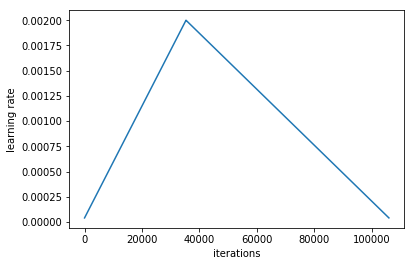

In [23]:
learner.sched.plot_lr()

In [43]:
lrs = 5e-4
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 3), cycle_len=10, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      3.849988   3.651798  
    1      3.843731   3.652289                                  
    2      3.851551   3.653735                                  
    3      3.851972   3.649651                                  
    4      3.841882   3.643531                                  
    5      3.83303    3.639206                                  
 73%|███████▎  | 7710/10598 [12:47<04:47, 10.05it/s, loss=3.81]

KeyboardInterrupt: 

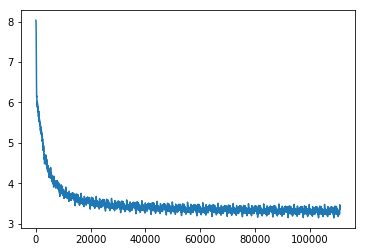

In [14]:
learner.sched.plot_loss()

In [44]:
learner.save("lm_qrnn")
learner.save_encoder("lm_qrnn_enc")

In [ ]:
learner.load("lm_qrnn")

### LSTM

In [20]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

 89%|████████▉ | 12104/13546 [13:26<01:36, 15.01it/s, loss=21.1]

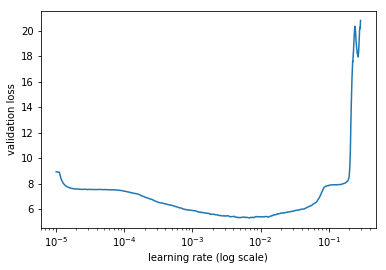

In [21]:
learner.clip = 25.
learner.lr_find(start_lr=1e-5, end_lr=1, linear=False)
learner.sched.plot()

In [22]:
lrs = 2e-3
learner.clip = 10.
learner.fit(lrs, 1, wds=1e-7, use_clr=(50, 5), cycle_len=20, use_wd_sched=True)

epoch      trn_loss   val_loss                                  
    0      5.215836   5.190686  
    1      4.762199   4.723144                                  
    2      4.634238   4.597062                                  
    3      4.597738   4.546328                                  
    4      4.541433   4.480604                                  
    5      4.488879   4.435633                                  
    6      4.519079   4.400683                                  
    7      4.478027   4.374083                                  
    8      4.454455   4.354053                                  
    9      4.41902    4.335179                                  
    10     4.403441   4.319366                                  
    11     4.387182   4.301155                                  
    12     4.367671   4.286514                                  
    13     4.390375   4.27139                                   
    14     4.359334   4.257734                           

[4.20485938572954]

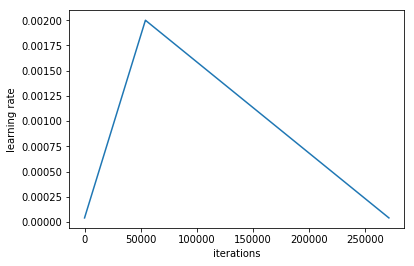

In [23]:
learner.sched.plot_lr()

In [24]:
learner.save("lm_lstm")
learner.save_encoder("lm_lstm_enc")

In [25]:
tmp_iter = iter(trn_loader)

In [26]:
next(tmp_iter)[0].shape

torch.Size([100, 64])

In [27]:
learner.load("lm_lstm")

## Test the model

In [28]:
learner.model.eval()

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(7500, 300, padding_idx=2)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(7500, 300, padding_idx=2)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(300, 500)
      )
      (1): WeightDrop(
        (module): LSTM(500, 500)
      )
      (2): WeightDrop(
        (module): LSTM(500, 300)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=300, out_features=7500, bias=False)
    (dropout): LockedDropout()
  )
)

### Next Character Inference

In [29]:
tokens = sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计")
tokens

[624,
 11,
 325,
 15,
 4582,
 25,
 9,
 3,
 33,
 1497,
 780,
 110,
 2610,
 22,
 468,
 2254,
 5091,
 302]

In [30]:
logits, _, _ = learner.model(T(tokens).unsqueeze(1))
logits.shape

torch.Size([18, 7500])

In [32]:
sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
preds = []
for i in range(1, 4):
      preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
# preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
pd.DataFrame({"orig": sp.EncodeAsPieces("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计") + [""], 
              "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

,orig,pred_1,pred_2,pred_3
0,▁德国,,,
1,▁是,▁人,▁的,▁、
2,▁世界,▁一,▁一个,▁最
3,▁大,▁上,▁最,▁第一
4,国,都,▁城市,地
5,▁之,"▁,",▁。,▁之一
6,▁一,▁地,▁首,▁
7,"▁,",▁部分,▁种,▁部
8,▁其,▁但,▁而,▁在
9,▁国内,次,间,▁目的


In [33]:
def eval(texts):
    learner.model[0].reset()
    tokens =sp.EncodeAsIds(texts)
    logits, _, _ = learner.model(T(tokens).unsqueeze(1))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": sp.EncodeAsPieces(texts) + [""], 
                  "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2]})

In [34]:
eval("在 现代 印刷 媒体 ， 卡通 是 一 种 通常 有 幽默 色")

,orig,pred_1,pred_2,pred_3
0,▁在,,,
1,▁现代,▁中国,▁此,▁
2,▁印,▁的,▁世界,"▁,"
3,刷,刷,第,地
4,▁媒体,▁的,厂,术
5,"▁,",▁中,▁的,▁上
6,▁卡,▁并,▁在,▁也
7,通,洛,拉,通
8,▁是,▁的,▁和,▁、
9,▁一,▁一,▁一个,▁在


In [35]:
eval("对 中国 与 南洋 发动 全面 的 战争 。 1990 年代 ， 中")

,orig,pred_1,pred_2,pred_3
0,▁对,,,
1,▁中国,应,立,待
2,▁与,▁的,▁大陆,▁共产党
3,▁南,▁中国,▁日本,▁美国
4,洋,韩,非,▁韩
5,▁发动,▁的,▁地区,▁各国
6,▁全面,▁了,▁战争,▁的
7,▁的,▁战争,▁的,▁冲突
8,▁战争,▁战争,▁,▁军事
9,▁。,"▁,",▁。,▁;


### Generate Sentence

In [38]:
import random

def generate_text(tokens, N=25):    
    preds = []          
    for i in range(N):   
        learner.model[0].reset()          
        logits, _, _ = learner.model(T(tokens).unsqueeze(1))
        probs = F.softmax(logits).data.cpu().numpy()[-1, :]
        candidates = np.argsort(probs)[::-1]
        while True:
            # Sampling
            candidate = np.random.choice(candidates, p=probs[candidates])
            # Greedy
            # candidate = np.argmax(probs[2:]) + 2
            if candidate > 2:
                print(probs[candidates][:3], probs[candidate])
                preds.append(candidate)
                break
        # for candidate in candidates:
        #     if candidate > 1 and ord(itos[candidate]) > 255 and (random.random() < probs[candidate] or probs[candidate] < 0.2):
        #         print(probs[candidate])
        #         preds.append(candidate)
        #         break
        # tokens  = [preds[-1]]# 
        tokens.append(int(preds[-1]))
        # tokens = [:1]
        print(sp.DecodeIds(tokens)) 
    
generate_text(sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 为主 ， "))

[0.04291 0.0423  0.02618] 0.0013843966
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同
[0.10472 0.07627 0.07372] 0.076274104
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比
[0.15038 0.03023 0.02856] 0.00042624318
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总
[0.22189 0.12401 0.10153] 0.22188854
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值
[0.1504  0.06313 0.03682] 0.0031659396
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由
[0.0387  0.03033 0.02606] 0.0056743114
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国
[0.09633 0.06727 0.03762] 0.00024163786
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国 18
[0.27967 0.05527 0.05384] 0.27966636
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国 18%
[0.14326 0.11038 0.04836] 0.036684465
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国 18% 上升
[0.48976 0.45215 0.01578] 0.48976147
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国 18% 上升 到
[0.05186 0.04695 0.03894] 0.051855497
德国 是 世界 大国 之 一 , 其 国内 生产 总 值 以 国际 汇率 为主 , 同比 总值 由 德国 18%

In [66]:
generate_text(sp.EncodeAsIds("在 现代 印刷 媒体 ， 卡通 是 一种 通常 有 幽默 色 "))

[0.97506 0.01226 0.00825] 0.9750611
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩
[0.83559 0.04486 0.036  ] 0.83559495
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的
[0.03492 0.03434 0.02071] 0.01365002
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书
[0.20237 0.15114 0.09289] 0.1511407
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写
[0.10959 0.09418 0.07117] 0.0037915832
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ;
[0.08627 0.04176 0.03191] 0.01967793
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这
[0.18533 0.11166 0.05222] 0.1853286
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是
[0.14327 0.05622 0.05524] 0.0006986763
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是 著名
[0.65443 0.01973 0.00888] 0.6544264
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是 著名 的
[0.06489 0.05421 0.04087] 0.00017740912
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是 著名 的 政府
[0.03978 0.01956 0.01909] 0.0023805078
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是 著名 的 政府 报
[0.48089 0.22837 0.06237] 0.4808946
在 现代 印刷 媒体 , 卡通 是 一种 通常 有 幽默 色彩 的 书写 ; 这 是 著名 的 政府 报刊
[0.18243 0.17771 0.1218 ] 0.011213382


In [86]:
generate_text(sp.EncodeAsIds("日本 后来 成为 第二次 世界大战 的 轴心国 之一 ， 对 中国 与 南洋 发动 全面 的 战争"))

[0.43081 0.31219 0.02412] 0.31218985
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。
[0.09316 0.02155 0.01732] 0.011699178
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而
[0.56726 0.07874 0.02239] 0.5672625
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 ,
[0.10341 0.07322 0.04963] 0.0005642737
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对
[0.48495 0.10053 0.05639] 0.48494536
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于
[0.14885 0.05723 0.03955] 0.0029351118
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于 美
[0.24355 0.08478 0.04076] 0.24354891
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于 美洲
[0.17117 0.11958 0.0536 ] 0.004210532
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于 美洲 各
[0.26917 0.05379 0.04492] 0.0272237
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于 美洲 各 国家
[0.37217 0.16012 0.04482] 0.37217194
日本 后来 成为 第二次 世界大战 的 轴心国 之一 , 对 中国 与 南洋 发动 全面 的 战争 。 然而 , 相对 于 美洲 各 国家 的
[0

In [87]:
generate_text(sp.EncodeAsIds("特朗普 政府 以为 加征 关税 会 令 中国 屈服 ， 这种 策略 肯定 会 适得其反 ， 如果 就业 和 财富"))

[0.10286 0.04762 0.04457] 0.0067385645
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到
[0.10195 0.08112 0.03197] 0.0022015504
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足
[0.82156 0.04465 0.01348] 0.8215556
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 ,
[0.0738  0.07276 0.06128] 0.0011793486
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他
[0.0742  0.05908 0.04904] 0.0008241439
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他 人才
[0.09709 0.09656 0.06932] 0.016789284
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他 人才 不
[0.25532 0.24028 0.03995] 0.25531706
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他 人才 不 会
[0.04018 0.03699 0.03237] 0.002694091
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他 人才 不 会 加入
[0.05874 0.0464  0.0344 ] 0.022298805
特朗普 政府 以为 加征 关税 会 令 中国 屈服 , 这种 策略 肯定 会 适得其反 , 如果 就业 和 财富 得到 满足 , 其他 人才 不 会 加入 
[0.25475 0.01834 0.00974]